In [10]:
import pickle
import sys
import spike.spike_analysis.wilcoxon as wilcox
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import matplotlib.patches as mpatches
from itertools import combinations
import importlib
import spike.spike_analysis.spike_recording as rec
def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))
    


In [11]:
novel_collection = unpickle_this('novel_collection.pkl')
cagemate_collection = unpickle_this('cagemate_collection.pkl')
novel_collection.analyze(timebin = 50, ignore_freq=0.5)
cagemate_collection.analyze(timebin = 50, ignore_freq=0.5)



All set to analyze
All set to analyze


# Neurons per recording

In [12]:
total_neurons = 0
total_good_neurons = 0
for recording in cagemate_collection.collection: 
    total_neurons += len(recording.freq_dict.keys())
    for neuron, freq in recording.freq_dict.items():
        if freq > 0.5:
            total_good_neurons += 1
        else:
            pass    
print(total_good_neurons, total_neurons)   
      

134 164


In [13]:
total_neurons = 0
total_good_neurons = 0
for recording in novel_collection.collection: 
    total_neurons += len(recording.freq_dict.keys())
    for neuron, freq in recording.freq_dict.items():
        if freq > 0.5:
            total_good_neurons += 1
        else:
            pass    
print(total_good_neurons, total_neurons)   
      

131 145


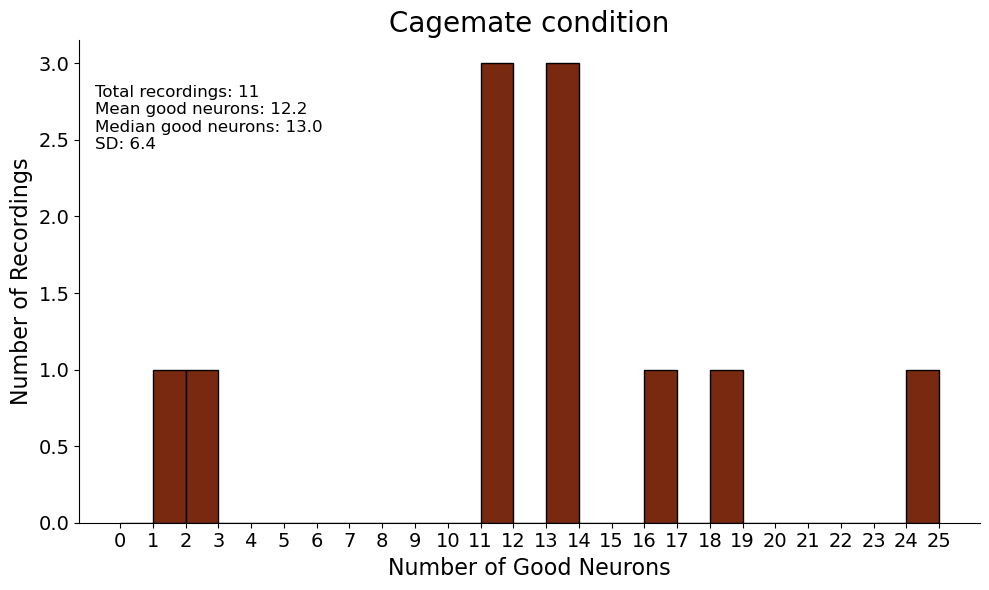

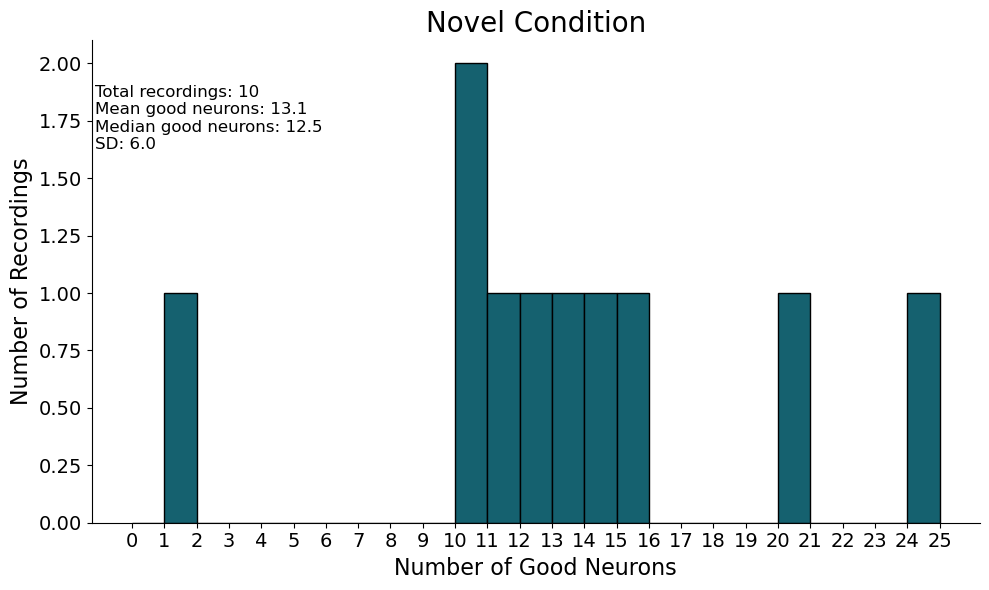

In [14]:
def plot_neuron_histogram(collection, title, color, bin_size=5):
   # Get counts of good neurons per recording
    recording_data = []

    for recording in collection.collection:
        total = len(recording.freq_dict.keys())
        good = sum(1 for freq in recording.freq_dict.values() if freq > 0.5)
        recording_data.append({
            'recording': recording.name,
            'total_neurons': total,
            'good_neurons': good
        })

    # Create DataFrame
    df = pd.DataFrame(recording_data)
   
    # Create histogram
    plt.figure(figsize=(10, 6))

    # Calculate number of bins based on bin_size
    bins = np.arange(0, max(df['good_neurons']) + bin_size, bin_size)

    plt.hist(df['good_neurons'], bins=bins, color=color, edgecolor='black')

    # Customize plot
    plt.xlabel('Number of Good Neurons', fontsize=16)
    plt.ylabel('Number of Recordings', fontsize=16)
    plt.title(f'{title}', fontsize=20)

    # Set ticks
    plt.xticks(bins, fontsize=14)
    plt.yticks(fontsize=14)

    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Add summary statistics as text
    plt.figtext(0.1, 0.85, 
                f'Total recordings: {len(df["good_neurons"])}\n'
                f'Mean good neurons: {np.mean(df["good_neurons"]):.1f}\n'
                f'Median good neurons: {np.median(df["good_neurons"]):.1f}\n'
                f'SD: {np.std(df["good_neurons"]):.1f}',
                fontsize=12, ha='left', va='top')

    plt.tight_layout()
    plt.show()

    return df

# Usage:
good_counts = plot_neuron_histogram(cagemate_collection, title = 'Cagemate condition', color = '#792910', bin_size=1)
good_counts_novel = plot_neuron_histogram(novel_collection, title = 'Novel Condition', color = '#15616F', bin_size = 1)

In [15]:
good_counts

,recording,total_neurons,good_neurons
0,11_cage_p1_merged.rec,19,13
1,12_cage_p1_merged.rec,24,18
2,13_cage_p1_merged.rec,14,11
3,21_cage_p1_merged.rec,33,25
4,22_cage_p1_merged.rec,13,13
5,24_cage_p1_merged.rec,12,11
6,31_cage_p1_merged.rec,1,1
7,32_cage_p1_merged.rec,15,13
8,33_cage_p1_merged.rec,2,2
9,41_cage_p1_merged.rec,15,11


In [16]:
good_counts_novel

,recording,total_neurons,good_neurons
0,11_nov_p1_merged.rec,21,20
1,12_nov_p1_merged.rec,21,15
2,13_nov_p1_merged.rec,11,11
3,21_nov_p1_merged.rec,10,10
4,22_nov_p1_merged.rec,12,12
5,24_nov_p1_merged.rec,12,10
6,32_nov_p1_merged.rec,13,13
7,33_nov_p1_merged.rec,1,1
8,41_nov_p1_merged.rec,27,25
9,44_nov_p1_merged.rec,17,14


# Wilcoxon: Presniff vs Sniff

In [18]:
from importlib import reload
reload(wilcox)
novel_collection.analyze(timebin = 100, ignore_freq=0.5)
cagemate_collection.analyze(timebin = 100, ignore_freq=0.5)
event_length = 3
baseline_window = 2
offset = 1
cagemate_dfs = []
novel_dfs = []
cagemate_event_length = 2
novel_event_length_dict = {'exp1': 4.5, 'exp4':2.5, 'exp5': 4}
events = ['exp1', 'exp4', 'exp5']
# Create first event's dataframes
cagemate_merged = wilcox.wilcoxon_collection(cagemate_collection, event=events[0], event_length=event_length, baseline_window=baseline_window, offset=offset, exclude_offset=True, plot=False)
novel_merged = wilcox.wilcoxon_collection(novel_collection, event=events[0], event_length=event_length, baseline_window=baseline_window, offset=offset, exclude_offset = True, plot=False)

# Merge remaining events with suffixes
for i, event in enumerate(events[1:], 1):
   suffix = f"_{event}"
   cagemate_df = wilcox.wilcoxon_collection(cagemate_collection, event=event, event_length=cagemate_event_length, baseline_window=baseline_window, offset=offset, plot=False)
   novel_df = wilcox.wilcoxon_collection(novel_collection, event=event, event_length=novel_event_length_dict[event], baseline_window=baseline_window, offset=offset, plot=False)
   
   cagemate_merged = pd.merge(cagemate_merged, cagemate_df, on=['Recording', 'Subject', 'original unit id'], suffixes=('', suffix))
   novel_merged = pd.merge(novel_merged, novel_df, on=['Recording', 'Subject', 'original unit id'], suffixes=('', suffix))

All set to analyze
All set to analyze
Wilcoxon can't be done on 33_cage_p1_merged.rec exp1, because <6 samples
Wilcoxon can't be done on 33_cage_p1_merged.rec exp4, because <6 samples
Wilcoxon can't be done on 44_cage_p1_merged.rec exp4, because <6 samples
Wilcoxon can't be done on 12_nov_p1_merged.rec exp4, because <6 samples
Wilcoxon can't be done on 11_cage_p1_merged.rec exp5, because <6 samples


In [19]:
comparisons = ['exp1', 'exp4', 'exp5']
base_columns = ['Subject', 'Recording', 'original unit id']
novel_master_df = novel_merged[base_columns].copy()

# Add comparison columns
for comp in comparisons:
   novel_master_df[f'{comp} vs baseline'] = novel_merged[f'event1 vs event2_{comp}' if comp != 'exp1' else 'event1 vs event2']

# Create trimmed version
novel_master_df_trimmed = novel_master_df[['original unit id'] + [f'{comp} vs baseline' for comp in comparisons]]
novel_master_df_trimmed

,original unit id,exp1 vs baseline,exp4 vs baseline,exp5 vs baseline
0,201,not significant,not significant,not significant
1,125,increases,not significant,not significant
2,210,not significant,not significant,not significant
3,268,increases,increases,not significant
4,9,not significant,not significant,increases
...,...,...,...,...
111,123,not significant,not significant,not significant
112,98,not significant,not significant,not significant
113,190,not significant,not significant,not significant
114,133,not significant,not significant,not significant


In [20]:

def group_cells(exp1, exp4, exp5):
    group = ''
    if (exp1 == 'increases') or (exp1 == 'decreases'):
        group = 'exp1'
    # if (exp2 == 'increases') or (exp2 == 'decreases'):
    #     group = group + 'exp2' 
    # if (exp3 == 'increases') or (exp3 == 'decreases'):
    #     group = group + 'exp3'
    if (exp4 == 'increases') or (exp4 == 'decreases'):
        group = group + 'exp4'
    if (exp5 == 'increases') or (exp5 == 'decreases'):
        group = group + 'exp5'
    return group

novel_master_df_trimmed['cell group'] = novel_master_df_trimmed.apply(lambda row: group_cells(row['exp1 vs baseline'],
                                                                  #row['exp2 vs baseline'],
                                                                  #row['exp3 vs baseline'],
                                                                  row['exp4 vs baseline'],
                                                                  row['exp5 vs baseline']), axis = 1)
results = novel_master_df_trimmed.groupby('cell group').count()
results

C:\Users\megha\AppData\Local\Temp\ipykernel_17644\2812253529.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novel_master_df_trimmed['cell group'] = novel_master_df_trimmed.apply(lambda row: group_cells(row['exp1 vs baseline'],


,original unit id,exp1 vs baseline,exp4 vs baseline,exp5 vs baseline
cell group,,,,
,98,98,98,98
exp1,6,6,6,6
exp1exp4,1,1,1,1
exp1exp5,1,1,1,1
exp4,2,2,2,2
exp5,8,8,8,8


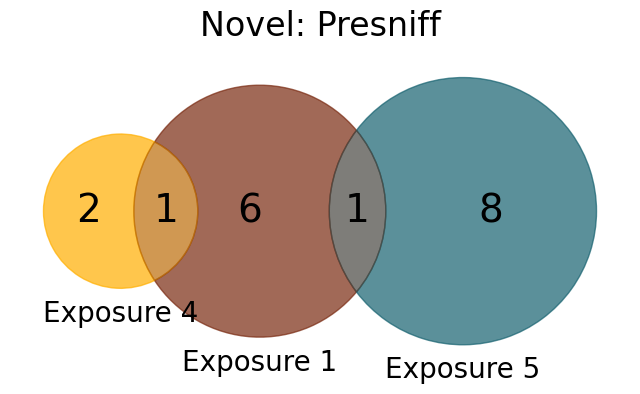

In [21]:
set1 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp1')])
set2 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp4')])
set3 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp5')])
from matplotlib_venn import venn3

plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Exposure 1', 'Exposure 4', 'Exposure 5'))
try:
   venn.get_patch_by_id('100').set_color('#792910') 
   venn.get_patch_by_id('100').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('010').set_color('#FFAF00') 
   venn.get_patch_by_id('010').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('001').set_color('#15616F')
   venn.get_patch_by_id('001').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('110').set_color('#bc6c08')
   venn.get_patch_by_id('110').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('101').set_color('#474640')
   venn.get_patch_by_id('101').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('011').set_color('#8a8838')
   venn.get_patch_by_id('011').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('111').set_color('#84682a')
   venn.get_patch_by_id('111').set_alpha(0.7)
except AttributeError:
   pass


    

for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(28) 
# Show the plot
plt.title('Novel: Presniff', fontsize =24)
plt.show()

In [22]:
comparisons = ['exp1', 'exp4', 'exp5']
base_columns = ['Subject', 'Recording', 'original unit id']
cagemate_master_df = cagemate_merged[base_columns].copy()

# Add comparison columns
for comp in comparisons:
   cagemate_master_df[f'{comp} vs baseline'] = cagemate_merged[f'event1 vs event2_{comp}' if comp != 'exp1' else 'event1 vs event2']

# Create trimmed version
cagemate_master_df_trimmed = cagemate_master_df[['original unit id'] + [f'{comp} vs baseline' for comp in comparisons]]
cagemate_master_df_trimmed

,original unit id,exp1 vs baseline,exp4 vs baseline,exp5 vs baseline
0,40,not significant,not significant,not significant
1,1,not significant,not significant,not significant
2,209,not significant,not significant,not significant
3,263,not significant,not significant,not significant
4,350,not significant,not significant,not significant
...,...,...,...,...
98,34,not significant,not significant,not significant
99,42,not significant,not significant,not significant
100,18,not significant,not significant,not significant
101,50,not significant,not significant,not significant


In [23]:
cagemate_master_df_trimmed['cell group'] = cagemate_master_df_trimmed.apply(lambda row: group_cells(row['exp1 vs baseline'],
                                                                  #row['exp2 vs baseline'],
                                                                  #row['exp3 vs baseline'],
                                                                  row['exp4 vs baseline'],
                                                                  row['exp5 vs baseline']), axis = 1)
results = cagemate_master_df_trimmed.groupby('cell group').count()
results

C:\Users\megha\AppData\Local\Temp\ipykernel_17644\3783352757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cagemate_master_df_trimmed['cell group'] = cagemate_master_df_trimmed.apply(lambda row: group_cells(row['exp1 vs baseline'],


,original unit id,exp1 vs baseline,exp4 vs baseline,exp5 vs baseline
cell group,,,,
,83,83,83,83
exp1,3,3,3,3
exp4,10,10,10,10
exp5,7,7,7,7


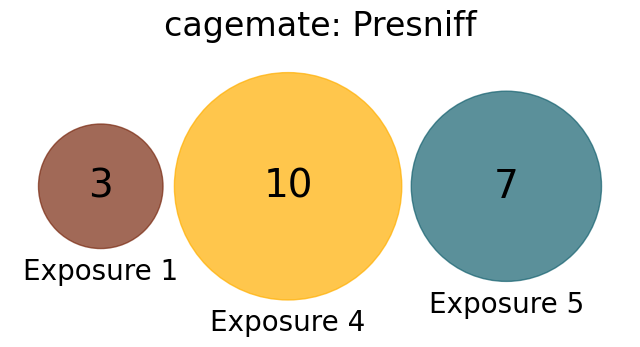

In [24]:
set1 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp1')])
set2 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp4')])
set3 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp5')])
from matplotlib_venn import venn3

plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Exposure 1', 'Exposure 4', 'Exposure 5'))
try:
   venn.get_patch_by_id('100').set_color('#792910') 
   venn.get_patch_by_id('100').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('010').set_color('#FFAF00') 
   venn.get_patch_by_id('010').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('001').set_color('#15616F')
   venn.get_patch_by_id('001').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('110').set_color('#bc6c08')
   venn.get_patch_by_id('110').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('101').set_color('#474640')
   venn.get_patch_by_id('101').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('011').set_color('#8a8838')
   venn.get_patch_by_id('011').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('111').set_color('#84682a')
   venn.get_patch_by_id('111').set_alpha(0.7)
except AttributeError:
   pass

for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(28) 
# Show the plot
plt.title('cagemate: Presniff', fontsize =24)
plt.show()

# Wilcoxon: Baseline vs Sniff

In [40]:
from importlib import reload
reload(wilcox)
novel_collection.analyze(timebin = 100, ignore_freq=0.5)
cagemate_collection.analyze(timebin = 100, ignore_freq=0.5)
event_length = 3
baseline_window = 2
offset = 0
cagemate_dfs = []
novel_dfs = []
cagemate_event_length = 2
novel_event_length_dict = {'exp1': 4.5, 'exp4':2.5, 'exp5': 4}
events = ['exp1', 'exp4', 'exp5']
# Create first event's dataframes
cagemate_merged = wilcox.wilcoxon_event1v2_collection(cagemate_collection, event1=events[0], event2 = 'baseline', event_length=event_length, pre_window = 0, plot=False)
novel_merged = wilcox.wilcoxon_event1v2_collection(novel_collection, event1=events[0], event2 = 'baseline', event_length=event_length, pre_window = 0, plot=False)

# Merge remaining events with suffixes
for i, event in enumerate(events[1:], 1):
   suffix = f"_{event}"
   cagemate_df = wilcox.wilcoxon_event1v2_collection(cagemate_collection, event1=event, event2 = 'baseline', event_length=cagemate_event_length, pre_window = 0, plot=False)
   novel_df = wilcox.wilcoxon_event1v2_collection(novel_collection, event1=event, event2 = 'baseline', event_length=novel_event_length_dict[event], pre_window = 0, plot=False)
   
   cagemate_merged = pd.merge(cagemate_merged, cagemate_df, on=['Recording', 'Subject', 'original unit id'], suffixes=('', suffix))
   novel_merged = pd.merge(novel_merged, novel_df, on=['Recording', 'Subject', 'original unit id'], suffixes=('', suffix))

All set to analyze
All set to analyze
Wilcoxon can't be done on 33_cage_p1_merged.rec because <6 samples for either exp1 or baseline
Wilcoxon can't be done on 33_cage_p1_merged.rec because <6 samples for either exp4 or baseline
Wilcoxon can't be done on 44_cage_p1_merged.rec because <6 samples for either exp4 or baseline
Wilcoxon can't be done on 12_nov_p1_merged.rec because <6 samples for either exp4 or baseline
Wilcoxon can't be done on 11_cage_p1_merged.rec because <6 samples for either exp5 or baseline


C:\Users\megha\AppData\Local\Temp\ipykernel_54932\371303454.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novel_master_df_trimmed['cell group'] = novel_master_df_trimmed.apply(lambda row: group_cells(row['exp1 vs baseline'],


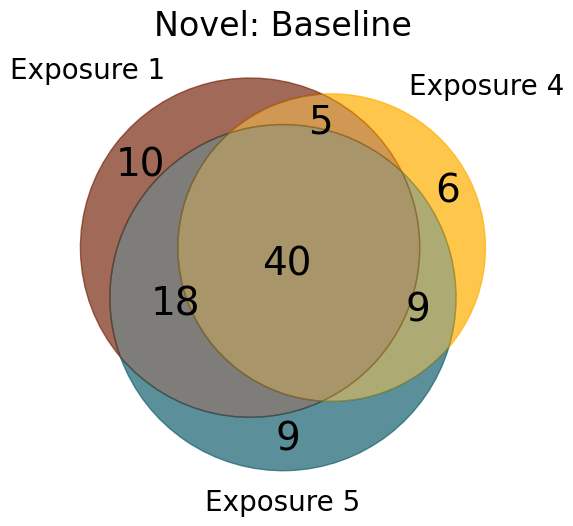

In [43]:
comparisons = ['exp1', 'exp4', 'exp5']
base_columns = ['Subject', 'Recording', 'original unit id']
novel_master_df = novel_merged[base_columns].copy()

# Add comparison columns
for comp in comparisons:
   novel_master_df[f'{comp} vs baseline'] = novel_merged[f'event1 vs event2_{comp}' if comp != 'exp1' else 'event1 vs event2']

# Create trimmed version
novel_master_df_trimmed = novel_master_df[['original unit id'] + [f'{comp} vs baseline' for comp in comparisons]]
novel_master_df_trimmed

def group_cells(exp1, exp4, exp5):
    group = ''
    if (exp1 == 'increases') or (exp1 == 'decreases'):
        group = 'exp1'
    # if (exp2 == 'increases') or (exp2 == 'decreases'):
    #     group = group + 'exp2' 
    # if (exp3 == 'increases') or (exp3 == 'decreases'):
    #     group = group + 'exp3'
    if (exp4 == 'increases') or (exp4 == 'decreases'):
        group = group + 'exp4'
    if (exp5 == 'increases') or (exp5 == 'decreases'):
        group = group + 'exp5'
    return group

novel_master_df_trimmed['cell group'] = novel_master_df_trimmed.apply(lambda row: group_cells(row['exp1 vs baseline'],
                                                                  #row['exp2 vs baseline'],
                                                                  #row['exp3 vs baseline'],
                                                                  row['exp4 vs baseline'],
                                                                  row['exp5 vs baseline']), axis = 1)
results = novel_master_df_trimmed.groupby('cell group').count()
results

set1 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp1')])
set2 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp4')])
set3 = set(novel_master_df_trimmed.index[novel_master_df_trimmed['cell group'].str.contains('exp5')])
from matplotlib_venn import venn3

plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Exposure 1', 'Exposure 4', 'Exposure 5'))
try:
   venn.get_patch_by_id('100').set_color('#792910') 
   venn.get_patch_by_id('100').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('010').set_color('#FFAF00') 
   venn.get_patch_by_id('010').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('001').set_color('#15616F')
   venn.get_patch_by_id('001').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('110').set_color('#bc6c08')
   venn.get_patch_by_id('110').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('101').set_color('#474640')
   venn.get_patch_by_id('101').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('011').set_color('#8a8838')
   venn.get_patch_by_id('011').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('111').set_color('#84682a')
   venn.get_patch_by_id('111').set_alpha(0.7)
except AttributeError:
   pass


    

for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(28) 
# Show the plot
plt.title('Novel: Baseline', fontsize =24)
plt.show()

C:\Users\megha\AppData\Local\Temp\ipykernel_54932\2359003080.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cagemate_master_df_trimmed['cell group'] = cagemate_master_df_trimmed.apply(lambda row: group_cells(row['exp1 vs baseline'],


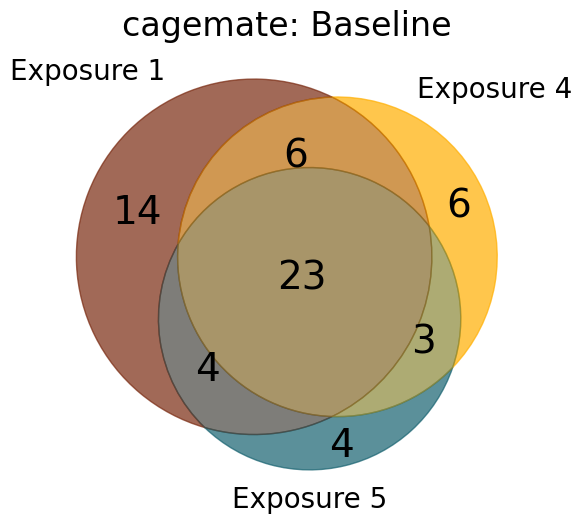

In [44]:
comparisons = ['exp1', 'exp4', 'exp5']
base_columns = ['Subject', 'Recording', 'original unit id']
cagemate_master_df = cagemate_merged[base_columns].copy()

# Add comparison columns
for comp in comparisons:
   cagemate_master_df[f'{comp} vs baseline'] = cagemate_merged[f'event1 vs event2_{comp}' if comp != 'exp1' else 'event1 vs event2']

# Create trimmed version
cagemate_master_df_trimmed = cagemate_master_df[['original unit id'] + [f'{comp} vs baseline' for comp in comparisons]]
cagemate_master_df_trimmed

def group_cells(exp1, exp4, exp5):
    group = ''
    if (exp1 == 'increases') or (exp1 == 'decreases'):
        group = 'exp1'
    # if (exp2 == 'increases') or (exp2 == 'decreases'):
    #     group = group + 'exp2' 
    # if (exp3 == 'increases') or (exp3 == 'decreases'):
    #     group = group + 'exp3'
    if (exp4 == 'increases') or (exp4 == 'decreases'):
        group = group + 'exp4'
    if (exp5 == 'increases') or (exp5 == 'decreases'):
        group = group + 'exp5'
    return group

cagemate_master_df_trimmed['cell group'] = cagemate_master_df_trimmed.apply(lambda row: group_cells(row['exp1 vs baseline'],
                                                                  #row['exp2 vs baseline'],
                                                                  #row['exp3 vs baseline'],
                                                                  row['exp4 vs baseline'],
                                                                  row['exp5 vs baseline']), axis = 1)
results = cagemate_master_df_trimmed.groupby('cell group').count()
results

set1 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp1')])
set2 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp4')])
set3 = set(cagemate_master_df_trimmed.index[cagemate_master_df_trimmed['cell group'].str.contains('exp5')])
from matplotlib_venn import venn3

plt.figure(figsize=(8, 6))
venn = venn3([set1, set2, set3], ('Exposure 1', 'Exposure 4', 'Exposure 5'))
try:
   venn.get_patch_by_id('100').set_color('#792910') 
   venn.get_patch_by_id('100').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('010').set_color('#FFAF00') 
   venn.get_patch_by_id('010').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('001').set_color('#15616F')
   venn.get_patch_by_id('001').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('110').set_color('#bc6c08')
   venn.get_patch_by_id('110').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('101').set_color('#474640')
   venn.get_patch_by_id('101').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('011').set_color('#8a8838')
   venn.get_patch_by_id('011').set_alpha(0.7)
except AttributeError:
   pass

try:
   venn.get_patch_by_id('111').set_color('#84682a')
   venn.get_patch_by_id('111').set_alpha(0.7)
except AttributeError:
   pass


    

for text in venn.set_labels:
    text.set_fontsize(20)  # Set label font size

for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(28) 
# Show the plot
plt.title('cagemate: Baseline', fontsize =24)
plt.show()

# auROC

All set to analyze


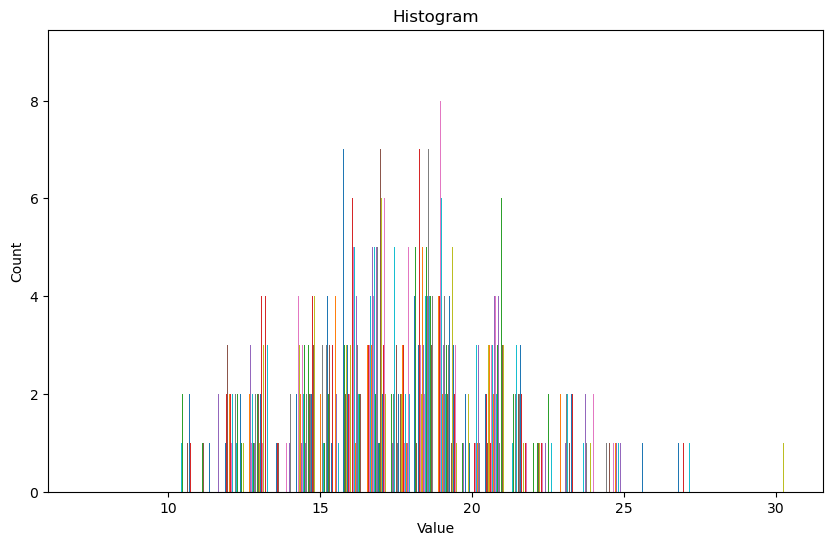

650


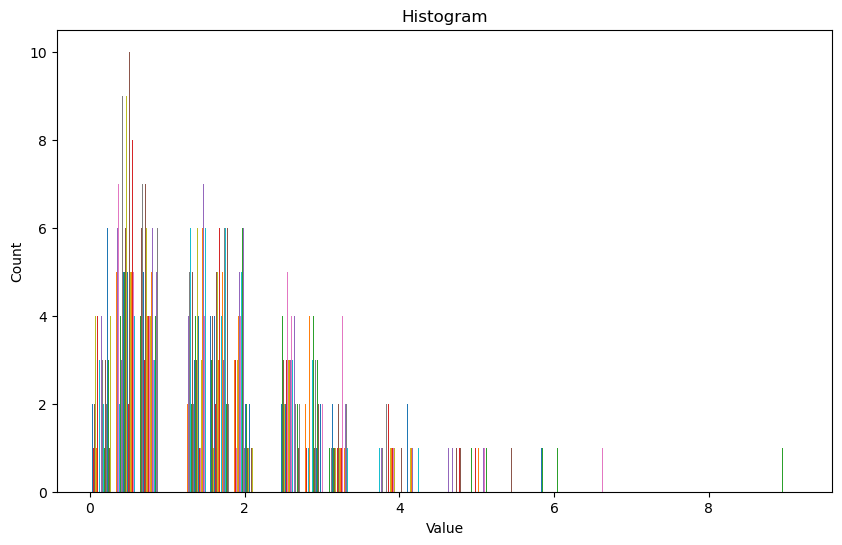

900


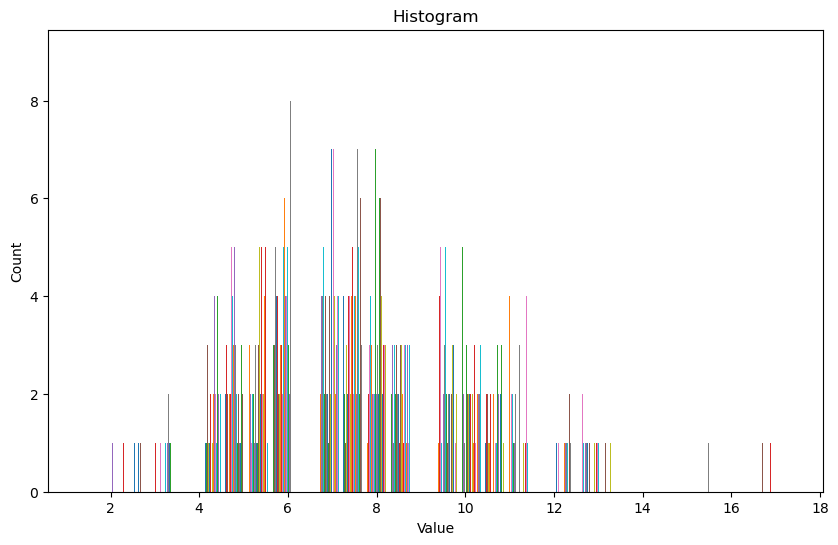

550


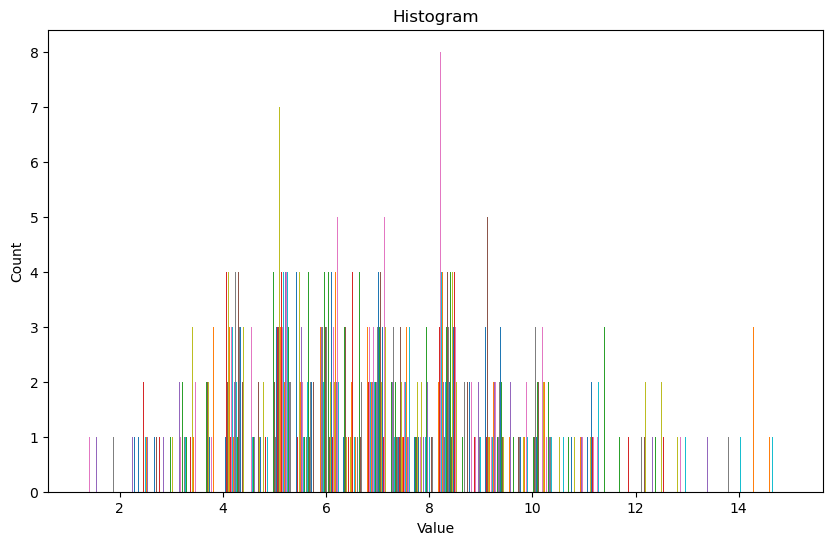

1250


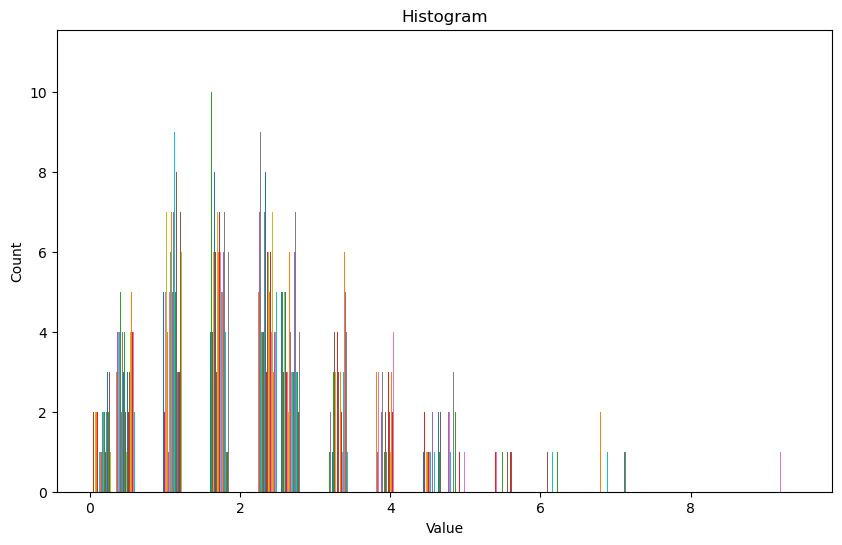

650


In [ ]:
from importlib import reload
reload(wilcox)

cagemate_collection.analyze(timebin = 100, ignore_freq= 0.5)
wilcox.bootstrap(cagemate_collection, 'exp1', 3, pre_window = 0, num_perm = 200)